# Manifold Learning

Applico il Manifold Learning sul Dataset Digits

## Caricamento del dataset

In [36]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y = True)

In [37]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1797, 64)
Shape of y: (1797,)


## Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

## Funzione `best_manifold` per il confronto tra parametri

In [39]:
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import random

def best_manifold(X, y, model, param_grid, metric="ami", n_iter=3,
                                          random_state=42):
    best_score = -np.inf
    best_params = None

    # Crea un campionamento casuale di combinazioni di parametri dalla griglia param_grid. Questo è più efficiente rispetto a esplorare tutte le combinazioni.
    sampler = ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state)

    # per ogni set di parametri generato dal sampler
    for params in sampler:
        try:
            # creo il modello usando i parametri specificati
            embedding = model(**params)
            # eseguo l'algoritmo di embedding per ottenere una nuova rappresentazione dei dati nel nuovo spazio (ad esempio, 2d o 3d), chiamata X_embedded
            X_embedded = embedding.fit_transform(X)

            # silhouette calcolato solo se specificato nei parametri del metodo e se l'output dell'embedding è di due dimensioni
            if metric == "silhouette" and X_embedded.shape[1] == 2:
                score = silhouette_score(X_embedded, y)

            elif metric == "ami":
                score = adjusted_mutual_info_score(y, np.argmax(X_embedded, axis=1))
            else:
                continue

            print(f"Executing function--Params: {params} => {metric.upper()} Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_params = params

        except Exception as e:
            print(f"Error with params {params}: {e}")

    return {"Best Params": best_params, "Best Score": best_score}

## Confronto tra spazio originale ed embedding
Voglio vedere come si comporta un Random Forest sullo spazio originale `X` e l'embedding creato con `t-SNE`.

### Creo l'embedding con t-SNE

In [40]:
from sklearn.manifold import TSNE

tsne_params_grid = {
    'n_components': [2, 3],
    'perplexity': [10, 20, 30, 40, 50],
    'early_exaggeration': [6, 12, 18],
    'learning_rate': ['auto', 10, 100, 500, 1000],
    'init': ['random', 'pca']
}

In [41]:
result = best_manifold(X = X_std,
                       y = y,
                       model = TSNE,
                       param_grid = tsne_params_grid,
                       metric = 'ami',
                       n_iter = 2)

Executing function--Params: {'perplexity': 30, 'n_components': 2, 'learning_rate': 'auto', 'init': 'random', 'early_exaggeration': 12} => AMI Score: 0.2660
Executing function--Params: {'perplexity': 10, 'n_components': 2, 'learning_rate': 100, 'init': 'pca', 'early_exaggeration': 18} => AMI Score: 0.3210


### Estraggo i parametri migliori e la metrica migliore corrispondente

In [42]:
best_params = result['Best Params']
best_score = result['Best Score']

print(f'Best parameters {best_params}')
print(f'Best score {best_score}')

Best parameters {'perplexity': 10, 'n_components': 2, 'learning_rate': 100, 'init': 'pca', 'early_exaggeration': 18}
Best score 0.32098535090299435


In [52]:
X_embedded = TSNE(n_components = best_params['n_components'],
                  perplexity = best_params['perplexity'],
                  early_exaggeration = best_params['early_exaggeration'],
                  learning_rate = best_params['learning_rate'],
                  init = best_params['init']).fit_transform(X_std)

In [53]:
print(f"Shape of X after transformation: {X_embedded.shape}")
print(f"Shape of y: {y.shape}")

Shape of X after transformation: (1797, 2)
Shape of y: (1797,)


## Valuto un modello semplice come un Random Forest sia sui dati standardizzati `X_std` che sull'embedding `X_embedded`

In [54]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

## Funzione di K-fold Cross Validation per valutare un modello con la CV semplice (non annidata)

In [55]:
# cross_val_score calcola gli scores del modello usando la cv specificata
from sklearn.model_selection import KFold, cross_val_score
import numpy as np


def evaluate_with_kfold(model, X, y, n_splits=5):
    # verifica delle dimensioni per assicurarsi che il numero di campioni in X corrisponda al numero di etichette
    if len(X) != len(y):
        print(f"Error: Mismatched lengths - X: {len(X)}, y: {len(y)}")
        return None

    # definizione del k-fold
    # n_splits specifica il numero di fold
    # shuffle mischia i dati prima di suddividerli

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    try:
        # valutazione del modello in ogni modello in ognuno dei fold
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

        # media e deviazione standard dei punteggi sui fold
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        return mean_acc, std_acc
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        return None


X_std = scaler.fit_transform(X)

In [56]:
result_rf = evaluate_with_kfold(model = random_forest,
                                X = X_std,
                                y = y,
                                n_splits = 5)

print(result_rf)

Mean Accuracy: 0.9755 ± 0.0048
(0.9755137728257506, 0.004796626387410299)


In [58]:
random_forest_embedded = RandomForestClassifier()

In [59]:
result_rf_embedded = evaluate_with_kfold(model = random_forest_embedded,
                                         X = X_embedded,
                                         y = y,
                                         n_splits = 5)

print(result_rf)

Mean Accuracy: 0.9761 ± 0.0028
(0.9755137728257506, 0.004796626387410299)


# Funzione di plot embedding per la visualizzazione

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting


def plot_embedding(X_embedded, y, title):
    dim = X_embedded.shape[1]
    if dim not in [2, 3]:
        raise ValueError("Embedding dimension must be 2 or 3 for visualization.")

    plt.figure(figsize=(8, 6))
    if dim == 2:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    else:  # 3D plot
        ax = plt.axes(projection='3d')
        sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2],
                        c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

    plt.title(title)
    plt.tight_layout()
    plt.show()

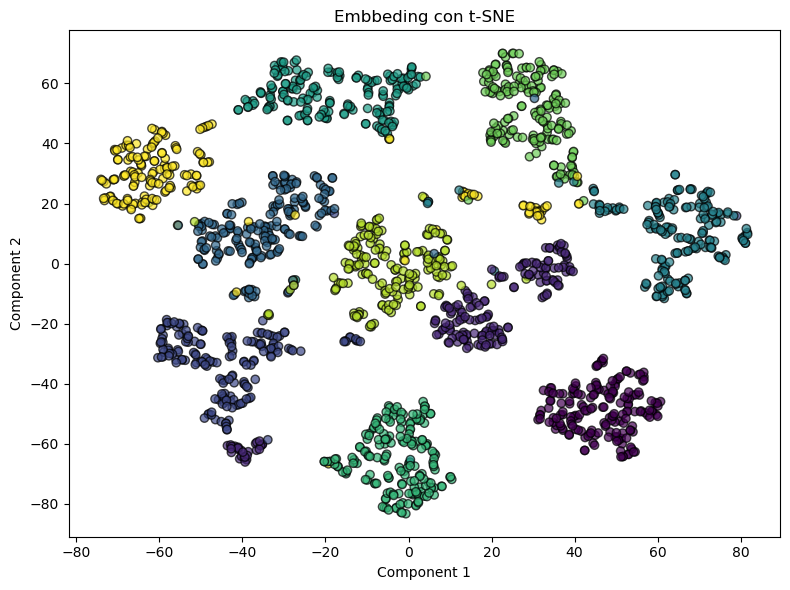

In [61]:
plot_embedding(X_embedded, y, "Embbeding con t-SNE")